In [1]:
from neuron import h
import os
import numpy as np
import matplotlib.pyplot as plt
from plots import plot_cell, plot_cell_with_electrode, plot_bc_rgc
from BC_model_template import ONBipolarCell
from helperFuns import move_rgc_along_z
from Stimulation import Stimulus
import matplotlib.pyplot as plt

--No graphics will be displayed.


In [2]:
# Load compiled channel mechanisms and standard run system
h.nrn_load_dll("/Users/lillikiessling/Documents/Stanford/Code/BC_model/Ion_channels/arm64/libnrnmech.dylib")
h.load_file('stdrun.hoc') 
#h.load_file("nrn/cells/gc.nrn")            # defines soma, dend1[], dend2[], dend3[], dend4[], dend5[], dend6[]
h.load_file("RGC_model_Anna/RGC_20171004_S1W3C3_ON_S_200um_dend_low_14um_diameter_3um_axon_up_6um_axon_sections_20_axon_points_3000_axon_diam_1um.hoc")  # defines soma, dend[], axon[]
h.load_file("nrn/cells/BC_Euler9_ON.hoc")

1.0

In [3]:
SEED_MAP = 1                # reproducible mapping
ASSIGNMENT = "round_robin"  # or "random"

# --- Convergence knobs ---
N_BC = 10                   # number of bipolar cells converging onto 1 RGC  <-- adjustable
N_LOCS = 23                 # number of postsynaptic dendrite locations
N_RIBBONS_PER_LOC = 3       # ribbons per location (you used 3) -> total synapses = N_LOCS * N_RIBBONS_PER_LOC

# --- Synapse params ---
NumSites = 10
GMAX  = 0.00256 * 8
GMAXN = 0.00011 * 8
MG    = 0.5

### 1. RGC Cell

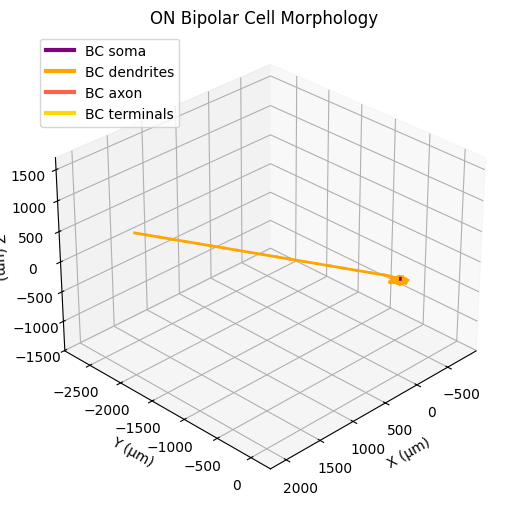

In [4]:
rgc_cell = h.RGC_20171004_S1W3C3_ON_S_200um_dend_low_14um_diameter_3um_axon_up_6um_axon_sections_20_axon_points_3000_axon_diam_1um()
move_rgc_along_z(rgc_cell, 100)
plot_cell(rgc_cell)

### 2. BC Cell

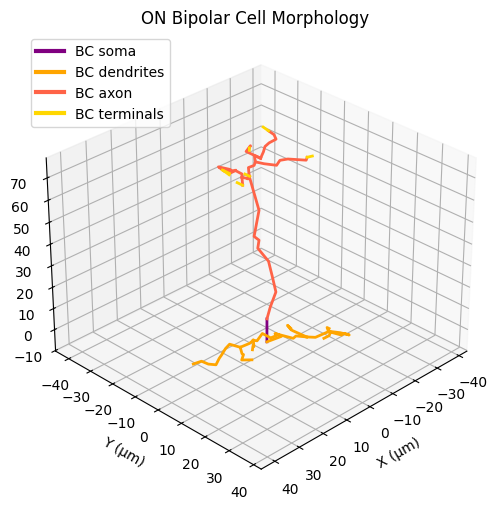

In [5]:
bc_cell = ONBipolarCell()
term_list = list(bc_cell.terminal)
preSyn = term_list[0]

# for sec in bc_cell.all:
#     sec.cao = 1.8 #mM
#     sec.cai = 0.0001 #mM
for sec in bc_cell.terminal:
    sec.cao = 1.8 #mM
    sec.cai = 0.0001 #mM
for sec in bc_cell.soma:
    sec.cao = 1.8 #mM
    sec.cai = 0.0001 #mM

#preSyn.gcabar_Bip_CaL = 0.4352 * 10 # TODO: verify hyperparameter
preSyn.gcabar_Bip_CaL = 150 / 1000  # updated hyperparameter

plot_cell(bc_cell)

### 3. Connect with ribbon tiger synapse

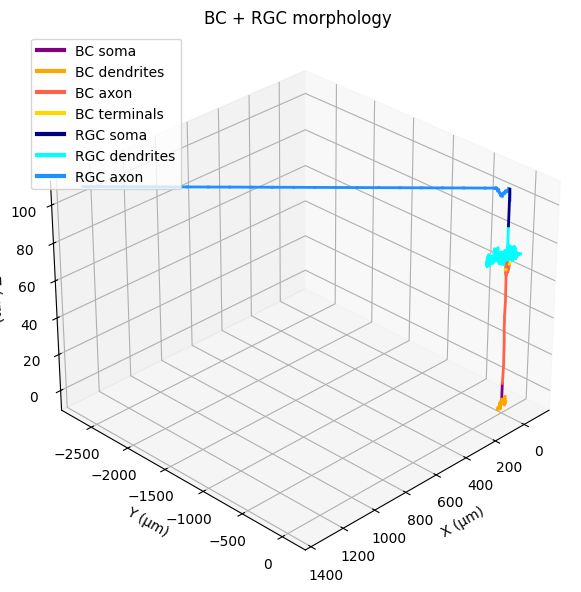

In [6]:
plot_bc_rgc(bc_cell, rgc_cell)

def make_syn_at(sec, idx):
    """Create a ribbon_tiger at sec(0.5) with Ca pointers hooked up."""
    syn = h.ribbon_tiger_simple(sec(0.5))
    h.setpointer(preSyn(0.5).ca_ion._ref_cai,  'preCA', syn)
    return syn

def pick_random_dend_indices(rgc_cell, n_locs=23, seed=0):
    rng = np.random.default_rng(seed)
    all_idx = np.arange(len(rgc_cell.dend))
    chosen = rng.choice(all_idx, size=n_locs, replace=False)
    return chosen.tolist()

syn_locs = pick_random_dend_indices(rgc_cell, n_locs=23, seed=1)

synapse  = [None]*len(syn_locs)
synapse2 = [None]*len(syn_locs)
synapse3 = [None]*len(syn_locs)

for idx, dend_idx in enumerate(syn_locs):
    sec = rgc_cell.dend[dend_idx]
    synapse[idx]  = make_syn_at(sec, idx)
    synapse2[idx] = make_syn_at(sec, idx)
    synapse3[idx] = make_syn_at(sec, idx)

def set_stim(gmax = GMAX, gmaxn = GMAXN):
    for arr in (synapse, synapse2, synapse3):
        for s in arr:
            if s is None:
                continue
            s.gmax       = gmax
            s.gmaxN      = gmaxn
            s.mg         = 0.5
set_stim()

### 4. Point source Stimulation at BC dendrites

##### Set up recording vectors

In [7]:
t_vec = h.Vector().record(h._ref_t)

# Panel A: bipolar voltage at presynaptic terminal and dendrite
v_bc_pre = h.Vector().record(preSyn(0.5)._ref_v)
v_bc_soma = h.Vector().record(bc_cell.soma(0.5)._ref_v)


# --- Containers ---
v_bc_dend = {}
v_bc_axon = {}
# --- Record from all dendritic sections ---
for sec in bc_cell.dendritic:
    vec = h.Vector()
    vec.record(sec(0.5)._ref_v)
    v_bc_dend[sec.name()] = vec
# --- Record from all axonal sections ---
for sec in bc_cell.axonal:
    vec = h.Vector()
    vec.record(sec(0.5)._ref_v)
    v_bc_axon[sec.name()] = vec

print(f"Record from {len(v_bc_dend)} dendritic sections and {len(v_bc_axon)} axonal sections.")


# Panel B: presynaptic Ca2+
ca_pre = h.Vector().record(preSyn(0.5)._ref_cai) 

# Panel C: Release Rate (Orate) from all ribbon synapses
Orate_vecs = []
for arr in (synapse, synapse2, synapse3):
    for s in arr:
        v = h.Vector().record(s._ref_Orate)
        Orate_vecs.append(v)


# Panel D: Release Events (release_start[i])
release_event_flags = []
for arr in (synapse, synapse2, synapse3):
    for s in arr:
        for i in range(NumSites):
            v = h.Vector().record(s._ref_release_start[i])
            release_event_flags.append(v)


# Panel E: Synaptic Current (EPSC) from all ribbon synapses (sum of AMPA + NMDA from all ribbon synapses)
I_syn_vecs = []
for arr in (synapse, synapse2, synapse3):
    for s in arr:
        if s is None: 
            continue
        v = h.Vector().record(s._ref_i)
        I_syn_vecs.append(v)


# Panel F: RGC soma membrane voltage
v_rgc_soma = h.Vector().record(rgc_cell.soma(0.5)._ref_v)

# Panel G: 
ica_bc = h.Vector().record(preSyn(0.5)._ref_ica)
ina_bc = h.Vector().record(preSyn(0.5)._ref_ina)
ih_bc = h.Vector().record(preSyn(0.5)._ref_ih)
d = next(iter(bc_cell.dendritic))
ina_dend = h.Vector().record(d(0.5)._ref_ina)

Record from 11 dendritic sections and 13 axonal sections.


#### Set up extracellular stimulation

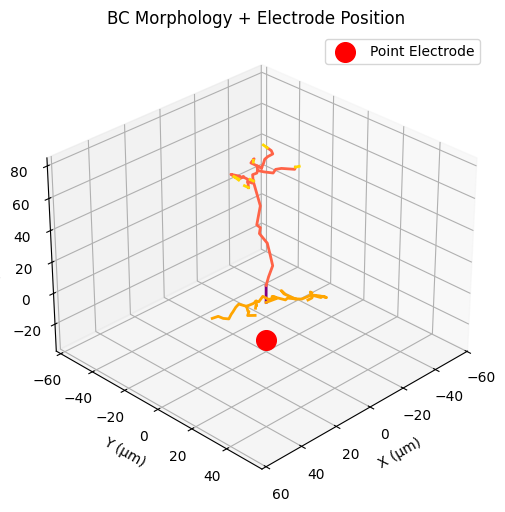

In [8]:
Stim_obj = Stimulus()
DELAY = 50
DURATION = 1

Stim, tsvec, isvec = Stim_obj.make_Stim(
    cell=bc_cell,
    duration=DURATION,
    delay=DELAY,
    amplitude=3,     
    type='extracellular',
    stimXShift=0,       # lateral offset 20
    stimYShift=0,
    stimZShift=-30,
)

plot_cell_with_electrode(bc_cell, Stim)

In [9]:
# Run simulation
#h.dt = 0.025 # ms
h.dt = 0.1 # ms
h.tstop = Stim['stop']
h.CVode().active(0)
h.finitialize(-65)
h.run()

Changed dt


0.0

In [10]:
t    = t_vec.as_numpy()
v_pre = v_bc_pre.as_numpy()
# v_dend = v_bc_dend.as_numpy()
# v_axon = v_bc_axon.as_numpy()
for sec_name, vec in v_bc_dend.items():
    v_bc_dend[sec_name] = vec.as_numpy()
for sec_name, vec in v_bc_axon.items():
    v_bc_axon[sec_name] = vec.as_numpy()
ca1  = ca_pre.as_numpy()
v_s  = v_rgc_soma.as_numpy()
v_bc_s = v_bc_soma.as_numpy()

ica_bc = ica_bc.as_numpy()
ina_bc = ina_bc.as_numpy()
ih_bc = ih_bc.as_numpy()
ina_dend = ina_dend.as_numpy()

# Compute averaged release rate (Panel C)
Orate_np = np.array([v.as_numpy() for v in Orate_vecs])
avg_rate = Orate_np.mean(axis=0) / NumSites

# Extract release event times: detect changes in release_start arrays
event_trains = []
for v in release_event_flags:
    arr = np.array(v)
    changes = np.where(np.diff(arr) != 0)[0]
    times = arr[changes + 1]
    event_trains.append(times)

# Compute EPSC (sum of synaptic currents)
I_syn_np = np.array([v.as_numpy() for v in I_syn_vecs])
EPSC = I_syn_np.sum(axis=0)      # nA
EPSC_pA = EPSC * 1000            # convert to pA

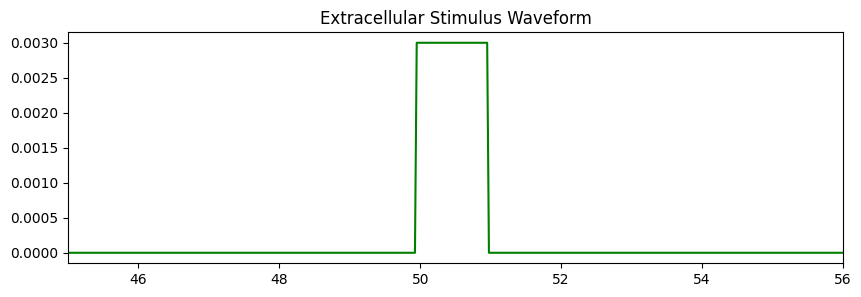

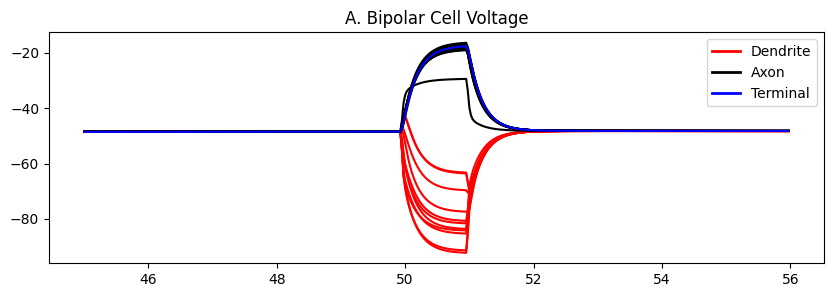

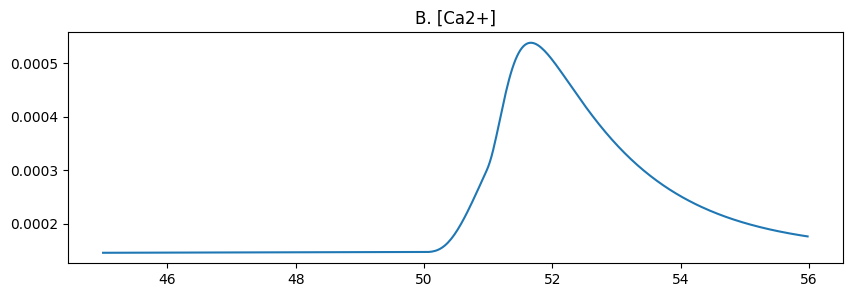

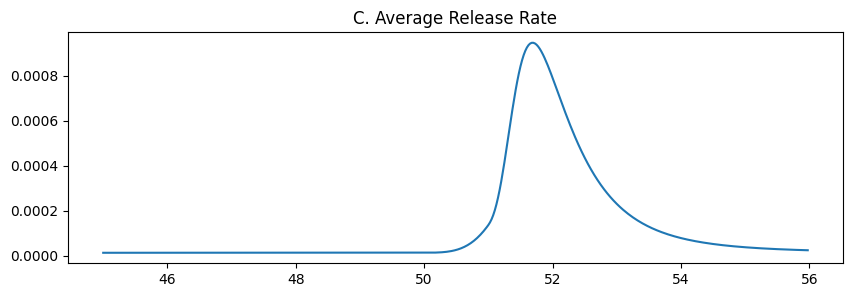

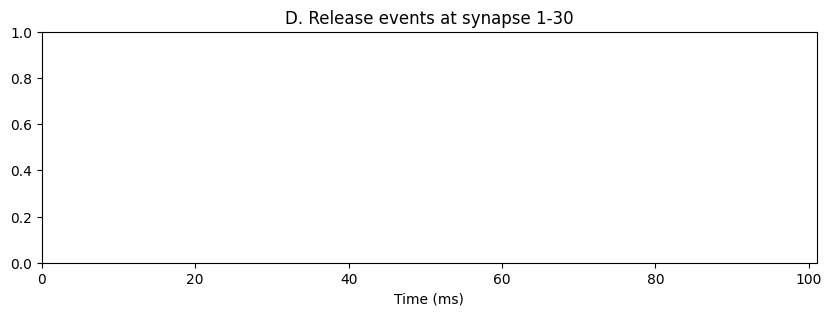

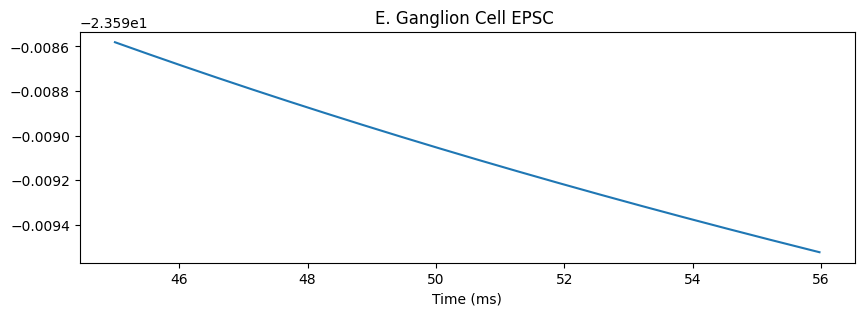

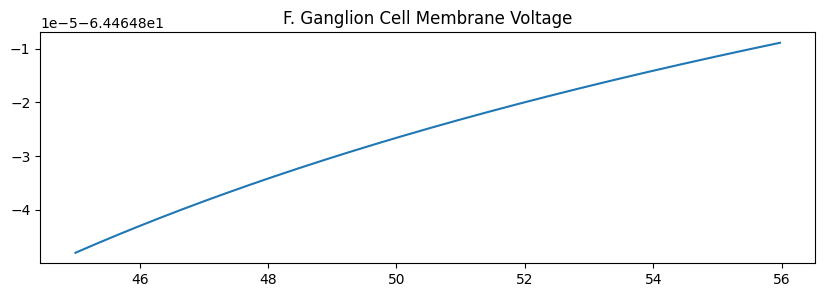

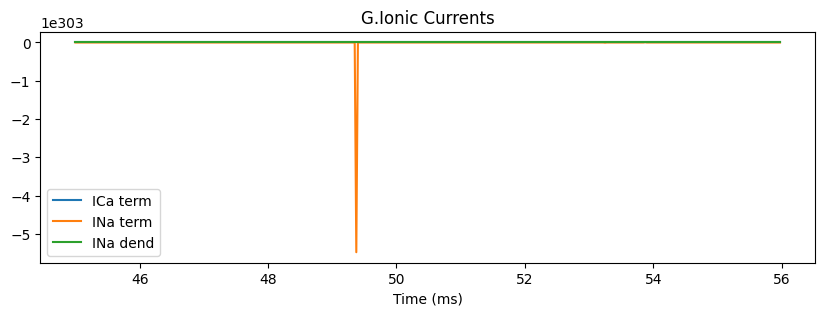

In [11]:
from matplotlib.lines import Line2D
# Stimulus
PAD = 5
tvalid = (t >= (DELAY - PAD)) & (t <= (DELAY + DURATION + PAD))
#tvalid = (t >= 1 & (t <= (DELAY + DURATION + 5)))

plt.figure(figsize=(10,3))
tsvec = np.array(tsvec)
isvec = np.array(isvec)
plt.plot(tsvec, isvec, label='Extracellular Stimulus (nA)', color='green')
plt.xlim(DELAY - PAD, DELAY + DURATION + PAD)
plt.title("Extracellular Stimulus Waveform")
plt.show()

# A — Bipolar Cell Voltage
plt.figure(figsize=(10, 3))
#plt.plot(t[100:], v_bc_s[100:], label="Soma")
for sec_name, v in v_bc_dend.items():
    plt.plot(t[tvalid], v[tvalid], color="red")
for sec_name, v in v_bc_axon.items():
    plt.plot(t[tvalid], v[tvalid], color="black")
plt.plot(t[tvalid], v_pre[tvalid], color="blue")
legend_elements = [
    Line2D([0], [0], color='red',   lw=2, label='Dendrite'),
    Line2D([0], [0], color='black', lw=2, label='Axon'),
    Line2D([0], [0], color='blue',  lw=2, label='Terminal'),
]
plt.legend(handles=legend_elements, loc="best")
plt.title("A. Bipolar Cell Voltage")
plt.show()

# B — Presynaptic Ca2+ at 25 nm depth (sharp increases during depolarization)
plt.figure(figsize=(10, 3))
plt.plot(t[tvalid], ca1[tvalid])
plt.title("B. [Ca2+]")
plt.show()


# C — Average Release Rate (Orate across 69 ribbon synapses -> smooth rate)
plt.figure(figsize=(10, 3))
plt.plot(t[tvalid], avg_rate[tvalid])
plt.title("C. Average Release Rate")
plt.show()

#D — Release Events (shows all vesicle release events -> raster of vertical tick marks)
k = 0
plt.figure(figsize=(10, 3))
for k in range(30):
    plt.vlines(event_trains[k], 0, 1)
plt.xlim(0, len(t)*h.dt)
plt.title(f"D. Release events at synapse 1-{k+1}")
plt.xlabel("Time (ms)")
plt.show()

# E —  Ganglion Cell EPSC = Sum of all AMPA+NMDA synaptic currents from all 69 synapses -> inward current during release bursts
plt.figure(figsize=(10, 3))
plt.plot(t[tvalid], EPSC_pA[tvalid])
plt.title("E. Ganglion Cell EPSC ")
plt.xlabel("Time (ms)")
plt.show()

# F — Ganglion Cell Membrane Voltage (shows natural RGC spiking, NOT voltage clamp -> action potentials during strong synaptic activation)
plt.figure(figsize=(10, 3))
plt.plot(t[tvalid], v_s[tvalid])
plt.title("F. Ganglion Cell Membrane Voltage")
plt.show()

# G — Bipolar Cell Ionic Currents (ICa, INa, Ih at presynaptic terminal)
plt.figure(figsize=(10, 3))
plt.plot(t[tvalid], ica_bc[tvalid], label='ICa term')
plt.plot(t[tvalid], ina_bc[tvalid], label='INa term')
#plt.plot(t, ih_bc, label='Ih term')
plt.plot(t[tvalid], ina_dend[tvalid], label='INa dend')
plt.title("G.Ionic Currents")
plt.xlabel("Time (ms)")
plt.legend()
plt.show()